#### Notebook for analysis of long-term carbon and climate dynamics in CMIP6 ESMs and CMIP6-era EMICs.  

Scenarios include the SSP5-8.5 and SSP5-3.4-overshoot in order to bracket the range of high and low emissions and their long-term implications.



In [1]:
def monthly_to_annual(array):
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [2]:
import numpy as np
import sys
import xarray as xr
from scipy.io import netcdf
import matplotlib.pyplot as plt
import cftime

plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10, 6]

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import pandas as pd

In [3]:
exps_list = ('historical','ssp585','ssp534-over','ssp126')
vars_list = ('tas','fgco2','nbp','cVeg','cSoil')
gridvars_list = ('areacella','areacello','sftlf','sftof')

models_list = ('CanESM5','CESM2-WACCM', 'IPSL-CM6A-LR', 'UKESM1', 'UVic-ESCM')

globally_gridded = [True, True, True, True, False]#, False]

nmodels = len(models_list)
nvars = len(vars_list)
nexps = len(exps_list)
n_future_scens = nexps-1
ngridvars = len(gridvars_list)


file_master_list_dynamics = [[[[] for i in range(nexps )] for j in range(nvars)] for k in range(nmodels)]
### index this file as [model_i][var_i][exp_i]

file_master_list_grids = [[[] for j in range(ngridvars)] for k in range(nmodels)]
### index this file as [model_i][gridvar_i]

startyear_list = [[[] for i in range(nexps )] for k in range(nmodels)]

startyear_exps = [1850, 2015, 2040, 2015]
endyear_exps = [2014, 2299, 2299, 2299]
nyears_total = 2299-1850+1
years = np.arange(nyears_total)+startyear_exps[0]

years_to_average_gmst = 50

ssp534os_color = [154./256., 109./256., 201./256.]
ssp585_color = [132./256., 11./256., 34./256.]
ssp126_color = 'blue'

dashlist = ['solid',(0, (10, 2)),'dotted','dashdot','--']#, (1, (7, 2,1,2,1,2))]


labels_list = tuple(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6', ''] + list(models_list))

oceanmodel_latvar_names = [[] for k in range(nmodels)]

lat_bin_edges_for_fgco2_zonalmean_plots = np.arange(-90., 92.5, 2.5)
lat_bin_centers_for_fgco2_zonalmean_plots = np.arange(-88.75, 88.75+2.5, 2.5)

#### lo-res ocean zonal-mean plots for debugging
#lat_bin_edges_for_fgco2_zonalmean_plots = np.arange(-90., 100., 10.)
#lat_bin_centers_for_fgco2_zonalmean_plots = np.arange(-85, 95., 10.)

### super lo-res ocean zonal-mean plots for debugging
#lat_bin_edges_for_fgco2_zonalmean_plots = np.arange(-90., 110., 20.)
#lat_bin_centers_for_fgco2_zonalmean_plots = np.arange(-80, 100., 20.)

n_lat_bins_fgco2_zonalmean = len(lat_bin_centers_for_fgco2_zonalmean_plots)

make_zonal_mean_fgco2_plots = True  ### this requires a regridding step so is slow (~30 mins). set to False if not needed.


In [4]:
ssp126_color = [0/256., 52./256., 106./256.]



In [5]:
### gather all the files for CanESM5

model_i = models_list.index('CanESM5')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Oyr_CanESM5_historical_r1i1p1f1_gn_1850-2014.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2101-2180.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('historical')] = [
'cSoil_Emon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp585')] = [
'cSoil_Emon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'cSoil_Emon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'cSoil_Emon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp534-over')] = [
'cSoil_Emon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'cSoil_Emon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('historical')] = [
'cVeg_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp585')] = [
'cVeg_Lmon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'cVeg_Lmon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'cVeg_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp534-over')] = [
'cVeg_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'cVeg_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]


file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp126')] = [
'tas_Amon_CanESM5_ssp126_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
'fgco2_Oyr_CanESM5_ssp126_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_CanESM5_ssp126_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp126')] = [
'nbp_Lmon_CanESM5_ssp126_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012.nc'
]



file_master_list_grids[model_i] = [
'areacella_fx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'areacello_Ofx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'sftof_Ofx_CanESM5_ssp585_r1i1p1f1_gn.nc'
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040
startyear_list[model_i][exps_list.index('ssp126')]      = 2015

oceanmodel_latvar_names[model_i] = 'latitude'

In [6]:
### gather all the files for CESM2-WACCM

model_i = models_list.index('CESM2-WACCM')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Omon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-208912.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_209001-210012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('historical')] = [
'cSoil_Emon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp585')] = [
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp534-over')] = [
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('historical')] = [
'cVeg_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp585')] = [
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp534-over')] = [
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp126')] = [
'tas_Amon_CESM2-WACCM_ssp126_r1i1p1f1_gn_201501-206412.nc',
'tas_Amon_CESM2-WACCM_ssp126_r1i1p1f1_gn_206501-210012.nc',
'b.e21.BWSSP126cmip6.f09_g17.CMIP6-SSP1-2.6ext-WACCM.001.tas.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
'fgco2_Omon_CESM2-WACCM_ssp126_r1i1p1f1_gn_201501-210012.nc',
'b.e21.BWSSP126cmip6.f09_g17.CMIP6-SSP1-2.6ext-WACCM.001.fgco2.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp126')] = [
'nbp_Lmon_CESM2-WACCM_ssp126_r1i1p1f1_gn_201501-210012.nc',
'b.e21.BWSSP126cmip6.f09_g17.CMIP6-SSP1-2.6ext-WACCM.001.nbp.nc'
]


    
file_master_list_grids[model_i] = [
'areacella_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'areacello_Ofx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'sftof_Ofx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc'
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040
startyear_list[model_i][exps_list.index('ssp126')]      = 2015

oceanmodel_latvar_names[model_i] = 'lat'

### due to the CESM2 spinup bug, we may need to filter out those points affected by it.  
### get the PI control GPP field, and create a mask based on those points that had zero GPP.

cesm2_gpp = xr.open_dataset('gpp_Lmon_CESM2-WACCM_piControl_r1i1p1f1_gn_045001-049912.nc')
cesm2_zerogppmask = cesm2_gpp['gpp'].mean(dim='time') > 0.
#cesm2_zerogppmask.plot()

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'gpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
### gather all the files for IPSL-CM6A-LR

model_i = models_list.index('IPSL-CM6A-LR')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Oyr_IPSL-CM6A-LR_historical_r1i1p1f1_gn_1850-2014.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('historical')] = [
'cSoil_Emon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp585')] = [
'cSoil_Emon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'cSoil_Emon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp534-over')] = [
'cSoil_Emon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'cSoil_Emon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('historical')] = [
'cVeg_Lmon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp585')] = [
'cVeg_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'cVeg_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp534-over')] = [
'cVeg_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'cVeg_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp126')] = [
'tas_Amon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gr_201501-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp126_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp126_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp126')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gr_201501-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_grids[model_i] = [
'areacella_fx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr.nc',
'areacello_Ofx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr.nc',
None
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040
startyear_list[model_i][exps_list.index('ssp126')]      = 2015

oceanmodel_latvar_names[model_i] = 'nav_lat'

In [8]:
### gather all the files for UKESM1

model_i = models_list.index('UKESM1')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_UKESM1-0-LL_historical_185001-201412_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_UKESM1-0-LL_historical_185001-201412_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_UKESM1-0-LL_historical_185001-201412_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_UKESM1-0-LL_ssp585_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_UKESM1-0-LL_ssp585_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_UKESM1-0-LL_ssp585_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_UKESM1-0-LL_ssp534-over_204001-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_UKESM1-0-LL_ssp534-over_204001-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_UKESM1-0-LL_ssp534-over_204001-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('historical')] = [
'cSoil_UKESM1-0-LL_historical_185001-201412_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp585')] = [
'cSoil_UKESM1-0-LL_ssp585_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp534-over')] = [
'cSoil_UKESM1-0-LL_ssp534-over_204001-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('historical')] = [
'cVeg_UKESM1-0-LL_historical_185001-201412_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp585')] = [
'cVeg_UKESM1-0-LL_ssp585_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp534-over')] = [
'cVeg_UKESM1-0-LL_ssp534-over_204001-230012_rename.nc'
]


file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp126')] = [
'tas_UKESM1-0-LL_ssp126_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
'fgco2_UKESM1-0-LL_ssp126_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp126')] = [
'nbp_UKESM1-0-LL_ssp126_201501-230012_rename.nc'
]

## only have regridded ocean vars right now, can use the land grid for ocean too when reading
file_master_list_grids[model_i] = [
'areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
'areacello_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
'sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
'sftof_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040
startyear_list[model_i][exps_list.index('ssp126')]      = 2015

oceanmodel_latvar_names[model_i] = 'latitude'

In [9]:
### gather all the files for UVic

model_i = models_list.index('UVic-ESCM')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = 'UVic_SSP5-85_global.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = 'UVic_SSP5-85_global.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = 'UVic_SSP5-85_global.nc'

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp126')] = 'tsi_126.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp126')] = 'tsi_126.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp126')] = 'tsi_126.nc'


### uvic provided separate gridded and spatially-integrated data files.
uvic_gridded_files = [None,None,None]
uvic_gridded_files[exps_list.index('historical')] = 'UVic_SSP5-34OS_spatial.nc'
uvic_gridded_files[exps_list.index('ssp585')] = 'UVic_SSP5-85_spatial.nc'
uvic_gridded_files[exps_list.index('ssp534-over')] = 'UVic_SSP5-34OS_spatial.nc'

## The lack of a grid here is going to be used to indicate that the data is already 
## globally integrated.
file_master_list_grids[model_i] = [
None
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 1850
startyear_list[model_i][exps_list.index('ssp534-over')] = 1850
startyear_list[model_i][exps_list.index('ssp126')]      = 1850


In [10]:
### load the terrestrial NBP flux
i_var = vars_list.index('nbp')
nbp_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_anual_nbp_list = []
for model_i in range(nmodels):
    zonal_mean_anual_nbp_list.append([])
    print(models_list[model_i])
    #
    if globally_gridded[model_i]:
        # load landmask and land areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
        sftlfvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftlf')])['sftlf']
    # s
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            if models_list[model_i] == 'UKESM1':
                dataset = dataset.rename({'latitude':'lat','longitude':'lon'})
            nbpvar = dataset['nbp']
            nbpvar.data = (np.ma.masked_invalid(nbpvar.data))
            if models_list[model_i] == 'CESM2-WACCM':
                # this is to apply the zero-productivity mask to remove the CESM spinup bug
                nbpvar = nbpvar * cesm2_zerogppmask
            global_nbp = (nbpvar * sftlfvar.data/100. * areavar.data).sum(dim="lat").sum(dim="lon").compute() * 86400. * 365. * 1e3 * 1e-15
            global_nbp_annual = monthly_to_annual(global_nbp)
            if models_list[model_i] == 'CESM2-WACCM' and exps_list[exp_i] == 'ssp126':
                len_cesm2_ssp126 = global_nbp_annual.count()
            try:
                nbp_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_nbp_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1].values
            except:
                nbp_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:startyear_exps[exp_i]-startyear_exps[0]+len(global_nbp_annual)] = global_nbp_annual
        else:
            if models_list[model_i] == 'UVic-ESCM':
                dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
                global_nbp_annual = dataset['F_carba2l']
                nbp_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_nbp_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]



CanESM5
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nbp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nbp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packag

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/cdkoven/miniconda2/envs/py3/lib/p

UKESM1
UVic-ESCM


In [11]:
### load the ocean fgco2 flux
i_var = vars_list.index('fgco2')
fgco2_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_anual_fgco2_list = []
for model_i in range(nmodels):
    print(models_list[model_i])
    #
    if(globally_gridded[model_i]):
        # load ocean mask and ocean areas
        if models_list[model_i] != 'UKESM1':
            area_ocean_var = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacello')])['areacello']
            if file_master_list_grids[model_i][gridvars_list.index('sftof')] != None:
                sftofvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftof')])['sftof']
            else:
                sftofvar = xr.DataArray([100.])
        else:
            area_ocean_var = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
            sftofvar = 100. - xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftlf')])['sftlf']
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            #f models_list[model_i] == 'UKESM1':
            #   dataset = dataset.rename({'latitude':'lat','longitude':'lon'})
            fgco2var = dataset['fgco2']
            if models_list[model_i] == 'CESM2-WACCM' or models_list[model_i] == 'UKESM1':
                fgco2var = monthly_to_annual(fgco2var)
            global_fgco2_annual = (fgco2var * sftofvar.data/100. * area_ocean_var.data).sum(dim=fgco2var.dims[1]).sum(dim=fgco2var.dims[2]) * 86400. * 365. * 1e3 * 1e-15
            try:
                fgco2_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_fgco2_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]
            except:
                fgco2_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:startyear_exps[exp_i]-startyear_exps[0]+len(global_fgco2_annual)] = global_fgco2_annual
        else:
            if models_list[model_i] == 'UVic-ESCM':
                dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
                global_fgco2_annual = dataset['F_carba2o']
                fgco2_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_fgco2_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]


CanESM5
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftof' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-pa

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/cdkoven/miniconda2/envs/py3/lib/p

UKESM1
UVic-ESCM


In [12]:
## load the global mean surface air temperature
i_var = vars_list.index('tas')
tas_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_tas_list = []
for model_i in range(nmodels):
    print(models_list[model_i])
    zonal_mean_tas_list.append([])
    #
    if(globally_gridded[model_i]):
        # load gridcell areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            if models_list[model_i] == 'UKESM1':
                dataset = dataset.rename({'latitude':'lat','longitude':'lon'})
            tasvar = dataset['tas']
            global_tas_annual = (monthly_to_annual(tasvar)  * areavar.data).sum(dim="lat").sum(dim="lon").compute() / areavar.sum(dim="lat").sum(dim="lon")
            try:
                tas_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_tas_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1] - 273.15
            except:
                tas_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:startyear_exps[exp_i]-startyear_exps[0]+len(global_tas_annual)] = global_tas_annual - 273.15
        else:
            if models_list[model_i] == 'UVic-ESCM':
                dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
                global_tas_annual = dataset['A_sat']
                tas_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_tas_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]


CanESM5
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/cdkoven/miniconda2/envs/py3/lib/p

UKESM1
UVic-ESCM


In [13]:
### now put the historical timeseries in front of the SSPs
tas_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])
nbp_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])
fgco2_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])

tas_trajectories_2exp[:,0,:] = tas_trajectories[:,0,:]
tas_trajectories_2exp[:,1,:] = tas_trajectories[:,0,:]
tas_trajectories_2exp[:,2,:] = tas_trajectories[:,0,:]
tas_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = tas_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
tas_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = tas_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
tas_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = tas_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]
tas_trajectories_2exp[:,2,startyear_exps[3]-startyear_exps[0]:] = tas_trajectories[:,3,startyear_exps[3]-startyear_exps[0]:]

nbp_trajectories_2exp[:,0,:] = nbp_trajectories[:,0,:]
nbp_trajectories_2exp[:,1,:] = nbp_trajectories[:,0,:]
nbp_trajectories_2exp[:,2,:] = nbp_trajectories[:,0,:]
nbp_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = nbp_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
nbp_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = nbp_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
nbp_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = nbp_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]
nbp_trajectories_2exp[:,2,startyear_exps[3]-startyear_exps[0]:] = nbp_trajectories[:,3,startyear_exps[3]-startyear_exps[0]:]

fgco2_trajectories_2exp[:,0,:] = fgco2_trajectories[:,0,:]
fgco2_trajectories_2exp[:,1,:] = fgco2_trajectories[:,0,:]
fgco2_trajectories_2exp[:,2,:] = fgco2_trajectories[:,0,:]
fgco2_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = fgco2_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
fgco2_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = fgco2_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
fgco2_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = fgco2_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]
fgco2_trajectories_2exp[:,2,startyear_exps[3]-startyear_exps[0]:] = fgco2_trajectories[:,3,startyear_exps[3]-startyear_exps[0]:]

### and smooth them all
nyear_smooth = 7
fgco2_trajectories_2exp = fgco2_trajectories_2exp.rolling(time=nyear_smooth).mean()
nbp_trajectories_2exp = nbp_trajectories_2exp.rolling(time=nyear_smooth).mean()
tas_trajectories_2exp = tas_trajectories_2exp.rolling(time=nyear_smooth).mean()


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


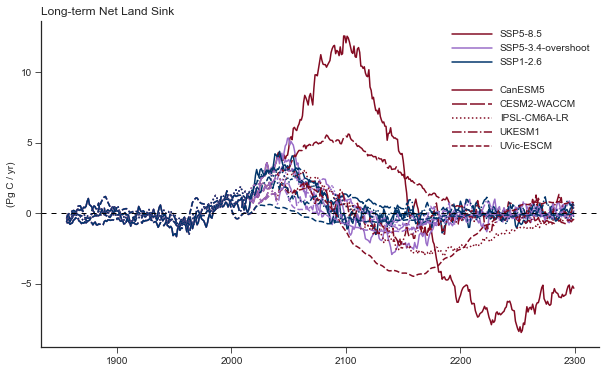

In [14]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, nbp_trajectories_2exp[model_i,0,:], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, nbp_trajectories_2exp[model_i,1,:], color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(years, nbp_trajectories_2exp[model_i,2,:], color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend(linelist, labels_list, frameon=False, handlelength=4)

plt.savefig('land_flux_timeseries.png', dpi=300, format='png')

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:2

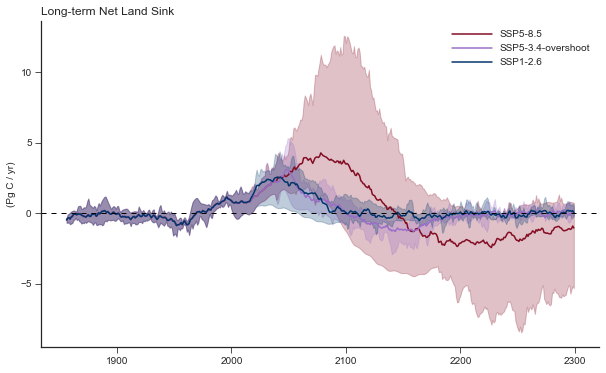

In [15]:
### plot ensemble mean and ranges across full ensemble

ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, nbp_trajectories_2exp[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,0,:].min(dim='models'), nbp_trajectories_2exp[:,0,:].max(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, nbp_trajectories_2exp[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,1,:].min(dim='models'), nbp_trajectories_2exp[:,1,:].max(dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, nbp_trajectories_2exp[:,2,:].mean(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,2,:].min(dim='models'), nbp_trajectories_2exp[:,2,:].max(dim='models'), color=ssp126_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a

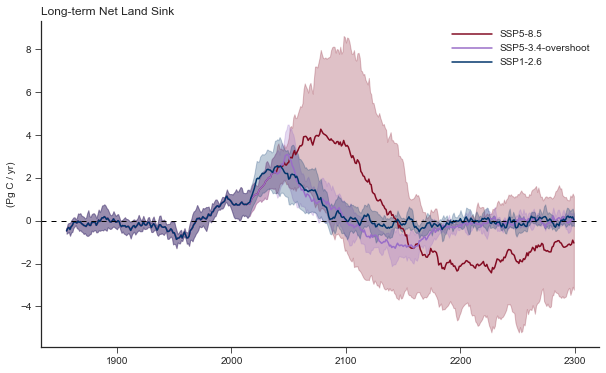

In [16]:
### plot ensemble mean and ranges, using plus/minus one standard deviation

ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, nbp_trajectories_2exp[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,0,:].mean(dim='models')-nbp_trajectories_2exp[:,0,:].std(dim='models'), nbp_trajectories_2exp[:,0,:].mean(dim='models')+nbp_trajectories_2exp[:,0,:].std(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, nbp_trajectories_2exp[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,1,:].mean(dim='models')-nbp_trajectories_2exp[:,1,:].std(dim='models'), nbp_trajectories_2exp[:,1,:].mean(dim='models')+nbp_trajectories_2exp[:,1,:].std(dim='models'), color=ssp534os_color, alpha=transparency)


a3, = ax.plot(years, nbp_trajectories_2exp[:,2,:].mean(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,2,:].mean(dim='models')-nbp_trajectories_2exp[:,2,:].std(dim='models'), nbp_trajectories_2exp[:,2,:].mean(dim='models')+nbp_trajectories_2exp[:,2,:].std(dim='models'), color=ssp126_color, alpha=transparency)


ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('landsink_timeseries_meanstd.png', dpi=300, format='png')


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  ove

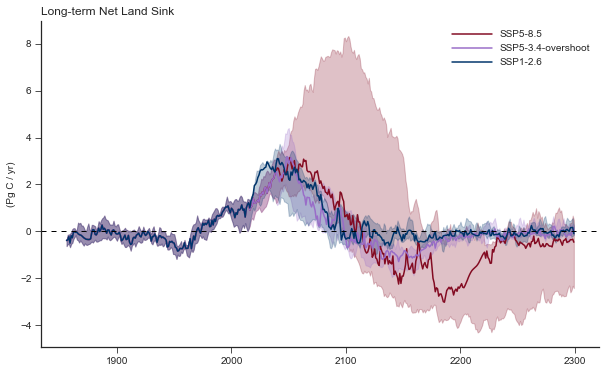

In [17]:
### plot ensemble median and 15-85%ile range

ax = plt.subplot(111)

transparency=0.25
envelope_quantile = 0.15

a1, = ax.plot(years, nbp_trajectories_2exp[:,0,:].median(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,0,:].quantile(envelope_quantile, dim='models'), nbp_trajectories_2exp[:,0,:].quantile(1.-envelope_quantile, dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, nbp_trajectories_2exp[:,1,:].median(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,1,:].quantile(envelope_quantile, dim='models'), nbp_trajectories_2exp[:,1,:].quantile(1.-envelope_quantile, dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, nbp_trajectories_2exp[:,2,:].median(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,2,:].quantile(envelope_quantile, dim='models'), nbp_trajectories_2exp[:,2,:].quantile(1.-envelope_quantile, dim='models'), color=ssp126_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('landsink_timeseries_medianqntle.png', dpi=300, format='png')


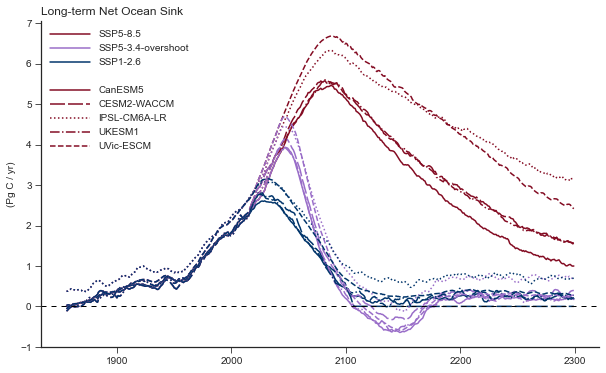

In [18]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, fgco2_trajectories_2exp[model_i,0,:], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, fgco2_trajectories_2exp[model_i,1,:], color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(years, fgco2_trajectories_2exp[model_i,2,:], color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)
        
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False, handlelength=4)
plt.savefig('ocean_flux_timeseries.png', dpi=300, format='png')

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:2

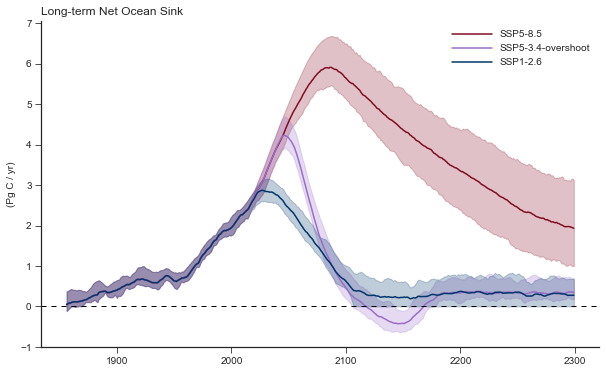

In [19]:
### plot ensemble mean and ranges, using full ensemble

ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, fgco2_trajectories_2exp[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,0,:].min(dim='models'), fgco2_trajectories_2exp[:,0,:].max(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, fgco2_trajectories_2exp[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,1,:].min(dim='models'), fgco2_trajectories_2exp[:,1,:].max(dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, fgco2_trajectories_2exp[:,2,:].mean(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,2,:].min(dim='models'), fgco2_trajectories_2exp[:,2,:].max(dim='models'), color=ssp126_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)




/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a

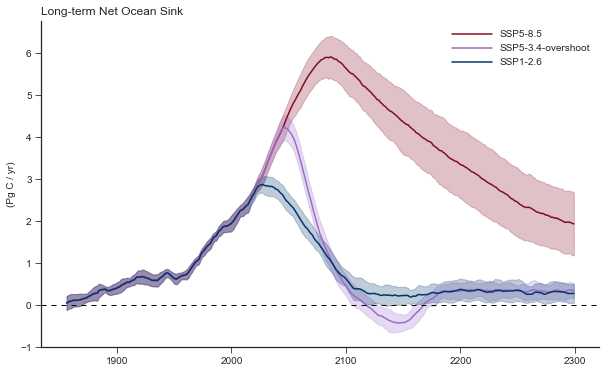

In [20]:
### plot ensemble mean and plus / minus one standard deviation

ax = plt.subplot(111)

transparency=0.25
envelope_quantile = 0.15

a1, = ax.plot(years, fgco2_trajectories_2exp[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,0,:].mean(dim='models')-fgco2_trajectories_2exp[:,0,:].std(dim='models'), fgco2_trajectories_2exp[:,0,:].mean(dim='models')+fgco2_trajectories_2exp[:,0,:].std(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, fgco2_trajectories_2exp[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,1,:].mean(dim='models')-fgco2_trajectories_2exp[:,1,:].std(dim='models'), fgco2_trajectories_2exp[:,1,:].mean(dim='models')+fgco2_trajectories_2exp[:,1,:].std(dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, fgco2_trajectories_2exp[:,2,:].mean(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,2,:].mean(dim='models')-fgco2_trajectories_2exp[:,2,:].std(dim='models'), fgco2_trajectories_2exp[:,2,:].mean(dim='models')+fgco2_trajectories_2exp[:,2,:].std(dim='models'), color=ssp126_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('oceansink_timeseries_meanstd.png', dpi=300, format='png')


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  ove

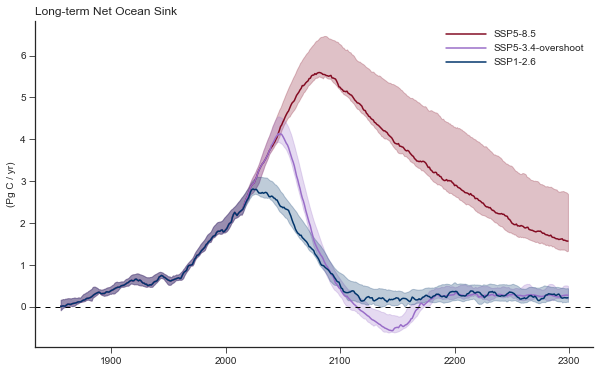

In [21]:
### plot ensemble median and 15th-8th percentile ranges

ax = plt.subplot(111)

transparency=0.25
envelope_quantile = 0.15

a1, = ax.plot(years, fgco2_trajectories_2exp[:,0,:].median(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,0,:].quantile(envelope_quantile, dim='models'), fgco2_trajectories_2exp[:,0,:].quantile(1.-envelope_quantile, dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, fgco2_trajectories_2exp[:,1,:].median(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,1,:].quantile(envelope_quantile, dim='models'), fgco2_trajectories_2exp[:,1,:].quantile(1.-envelope_quantile, dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, fgco2_trajectories_2exp[:,2,:].median(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,2,:].quantile(envelope_quantile, dim='models'), fgco2_trajectories_2exp[:,2,:].quantile(1.-envelope_quantile, dim='models'), color=ssp126_color, alpha=transparency)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('oceansink_timeseries_medianqntle.png', dpi=300, format='png')


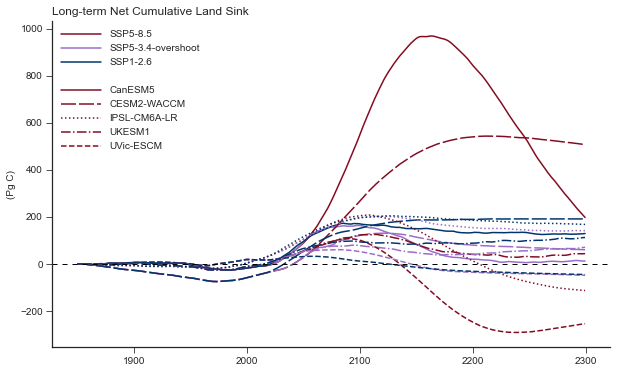

In [22]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, nbp_trajectories_2exp[model_i,0,:].cumsum(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, nbp_trajectories_2exp[model_i,1,:].cumsum(), color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(years, nbp_trajectories_2exp[model_i,2,:].cumsum(), color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)
   
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C)')
plt.title('Long-term Net Cumulative Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False, handlelength=4)


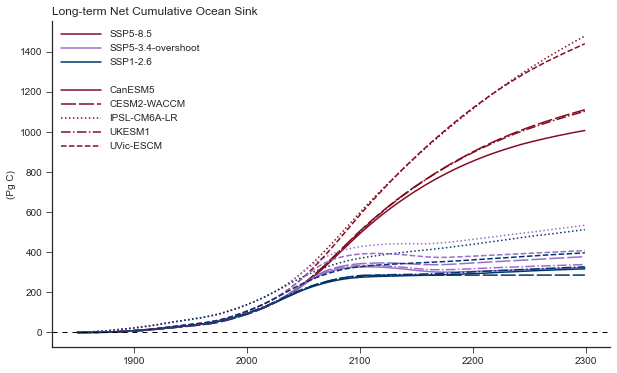

In [23]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, fgco2_trajectories_2exp[model_i,0,:].cumsum(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, fgco2_trajectories_2exp[model_i,1,:].cumsum(), color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(years, fgco2_trajectories_2exp[model_i,2,:].cumsum(), color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C)')
plt.title('Long-term Net Cumulative Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False, handlelength=4)


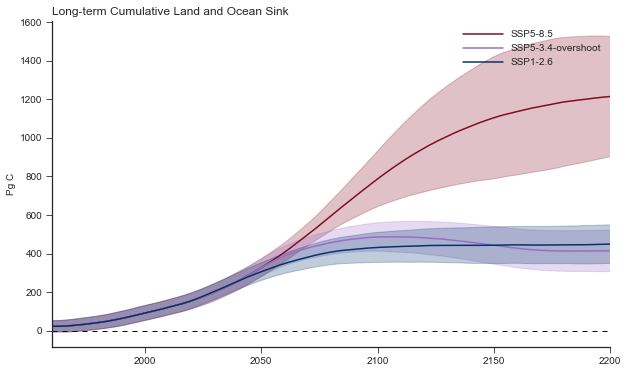

In [24]:
cumulative_sink = fgco2_trajectories_2exp.cumsum(dim='time') + nbp_trajectories_2exp.cumsum(dim='time')

ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, cumulative_sink[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, cumulative_sink[:,0,:].mean(dim='models')-cumulative_sink[:,0,:].std(dim='models'), cumulative_sink[:,0,:].mean(dim='models')+cumulative_sink[:,0,:].std(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, cumulative_sink[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, cumulative_sink[:,1,:].mean(dim='models')-cumulative_sink[:,1,:].std(dim='models'), cumulative_sink[:,1,:].mean(dim='models')+cumulative_sink[:,1,:].std(dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, cumulative_sink[:,2,:].mean(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, cumulative_sink[:,2,:].mean(dim='models')-cumulative_sink[:,2,:].std(dim='models'), cumulative_sink[:,2,:].mean(dim='models')+cumulative_sink[:,2,:].std(dim='models'), color=ssp126_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Pg C')
plt.title('Long-term Cumulative Land and Ocean Sink',loc='left')

plt.xlim([1960.,2200.])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('cumulative_sink_timeseries_meanstd.png', dpi=300, format='png')



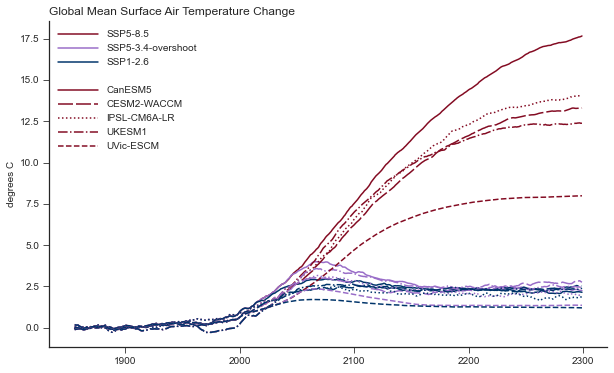

In [25]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(years, tas_trajectories_2exp[model_i,2,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('degrees C')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False, handlelength=4)

plt.savefig('global_temperature_timeseries.png', dpi=300, format='png')

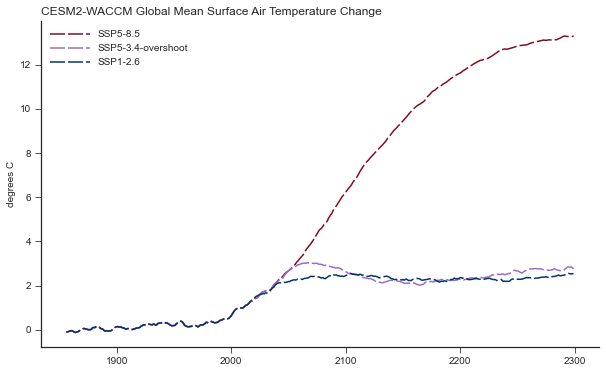

In [26]:
ax = plt.subplot(111)

linelist = []
model_i = models_list.index('CESM2-WACCM')
a1, = ax.plot(years, tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
a2, = ax.plot(years, tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
a3, = ax.plot(years, tas_trajectories_2exp[model_i,2,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp126_color, linestyle=dashlist[model_i])
linelist.append(a1)
linelist.append(a2)
linelist.append(a3)
emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
linelist.append(emptyline)
linelist.append(a1)

    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('degrees C')
plt.title('CESM2-WACCM Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist[0:3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('global_temperature_timeseries_cesm2.png', dpi=300, format='png')

In [27]:
## now load the atmospheric mole fraction of co2 to calculate the cumulative emissions
filename_atmco2_hist = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc'
filename_atmco2_ssp585 = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc'
filename_atmco2_ssp534os = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp534-over-1-2-1_gr1-GMNHSH_2015-2500.nc'
filename_atmco2_ssp126 = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc'

tmin_co2mf_hist = 0
tmin_co2mf_ssps = 2015


#startyear_exps = [1850, 2015, 2040]
#endyear_exps = [2014, 2299, 2299]

co2_mf_ts = xr.DataArray(np.ma.masked_all((3,nyears_total)), dims=['scenarios','time'])

co2_molefrac_hist = xr.open_dataset(filename_atmco2_hist, decode_times=False)
hist_co2_ts = co2_molefrac_hist['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[0]-tmin_co2mf_hist,endyear_exps[0]-tmin_co2mf_hist+1))
co2_mf_ts[:,0:endyear_exps[0]-startyear_exps[0]+1] = hist_co2_ts

co2_molefrac_ssp585 = xr.open_dataset(filename_atmco2_ssp585, decode_times=False)
ssp585_co2_ts = co2_molefrac_ssp585['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts[0,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp585_co2_ts

co2_molefrac_ssp534os = xr.open_dataset(filename_atmco2_ssp534os, decode_times=False)
ssp534os_co2_ts = co2_molefrac_ssp534os['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts[1,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp534os_co2_ts

co2_molefrac_ssp126 = xr.open_dataset(filename_atmco2_ssp126, decode_times=False)
ssp126_co2_ts = co2_molefrac_ssp126['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[3]-tmin_co2mf_ssps,endyear_exps[3]-tmin_co2mf_ssps+1))
co2_mf_ts[2,startyear_exps[3]-startyear_exps[0]:endyear_exps[3]-startyear_exps[0]+1] = ssp126_co2_ts

#co2_mf_ts.plot()


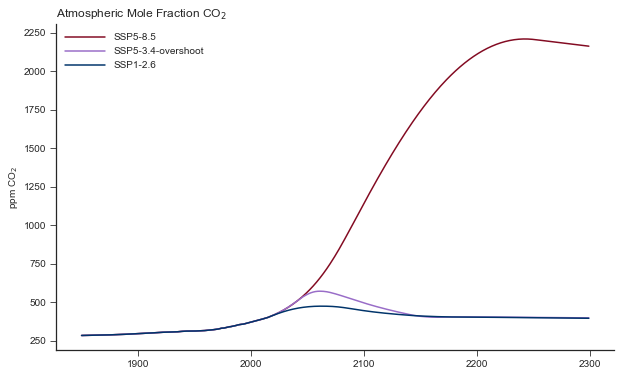

In [28]:
ax = plt.subplot(111)

ax.plot(years, co2_mf_ts[0,:], color=ssp585_color)
ax.plot(years, co2_mf_ts[1,:], color=ssp534os_color)
ax.plot(years, co2_mf_ts[2,:], color=ssp126_color)

    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('ppm CO$_2$')
plt.title('Atmospheric Mole Fraction CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6'], frameon=False, handlelength=4)
plt.savefig('co2_timeseries.png', dpi=300, format='png')

In [29]:
### now calculate cumulative emissions
ppm_to_pgc = 2.124  # from le quere 2018, which gets it from ballantyne et al 2012

atm_co2_pgc = (co2_mf_ts - co2_mf_ts.isel(time=0)) * ppm_to_pgc
cum_land_carbon_pgc = nbp_trajectories_2exp.cumsum(dim='time')
cum_ocn_carbon_pgc = fgco2_trajectories_2exp.cumsum(dim='time')

### filter out later CESM2-WACCM timepoints
#stopind_cesm2_ssp126 = int(len_cesm2_ssp126) + (2015-1850)
#cum_land_carbon_pgc[1,2,stopind_cesm2_ssp126:] = None
#cum_ocn_carbon_pgc[1,2,stopind_cesm2_ssp126:] = None

cum_emissions_pgc = atm_co2_pgc + cum_land_carbon_pgc + cum_ocn_carbon_pgc

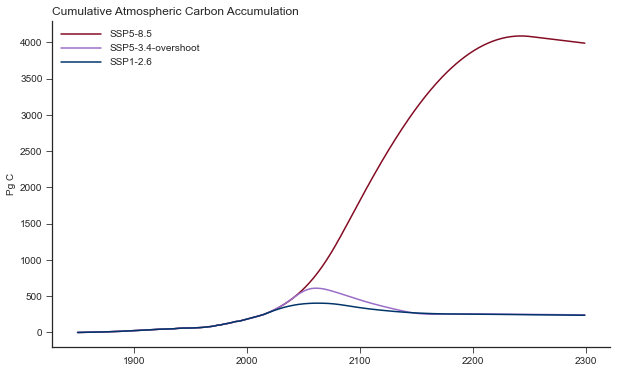

In [30]:
ax = plt.subplot(111)

ax.plot(years, atm_co2_pgc[0,:], color=ssp585_color)
ax.plot(years, atm_co2_pgc[1,:], color=ssp534os_color)
ax.plot(years, atm_co2_pgc[2,:], color=ssp126_color)

    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Pg C')
plt.title('Cumulative Atmospheric Carbon Accumulation',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6'], frameon=False, handlelength=4)

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


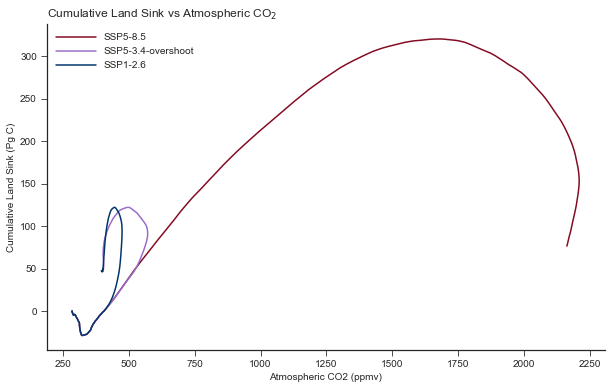

In [31]:
### playing around with some other ways of plotting things
ax = plt.subplot(111)

#ax.plot(cum_emissions_pgc[0,:].mean(dim='models'),nbp_trajectories_2exp[:,0,:].mean(dim='models').cumsum(), color=ssp585_color)
#ax.plot(cum_emissions_pgc[1,:].mean(dim='models'),nbp_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp534os_color)

ax.plot(co2_mf_ts[0,:],nbp_trajectories_2exp[:,0,:].mean(dim='models').cumsum(), color=ssp585_color)
ax.plot(co2_mf_ts[1,:],nbp_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp534os_color)
ax.plot(co2_mf_ts[2,:],nbp_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp126_color)


#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Cumulative Land Sink (Pg C)')
plt.xlabel('Atmospheric CO2 (ppmv)')
plt.title('Cumulative Land Sink vs Atmospheric CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6'], frameon=False, handlelength=4)

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


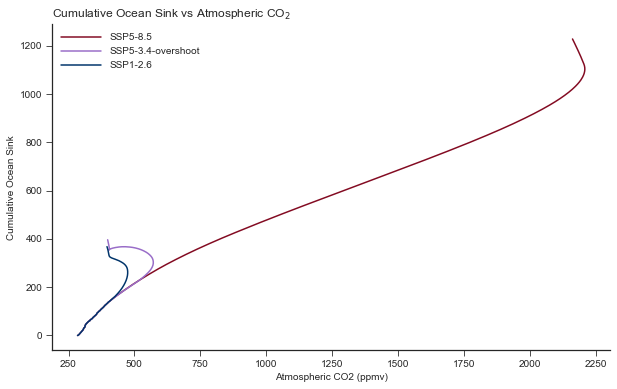

In [32]:
### playing around with some other ways of plotting things
ax = plt.subplot(111)

#ax.plot(cum_emissions_pgc[0,:].mean(dim='models'),fgco2_trajectories_2exp[:,0,:].mean(dim='models').cumsum(), color=ssp585_color)
#ax.plot(cum_emissions_pgc[1,:].mean(dim='models'),fgco2_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp534os_color)

ax.plot(co2_mf_ts[0,:],fgco2_trajectories_2exp[:,0,:].mean(dim='models').cumsum(), color=ssp585_color)
ax.plot(co2_mf_ts[1,:],fgco2_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp534os_color)
ax.plot(co2_mf_ts[2,:],fgco2_trajectories_2exp[:,2,:].mean(dim='models').cumsum(), color=ssp126_color)

    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Cumulative Ocean Sink')
plt.xlabel('Atmospheric CO2 (ppmv)')
plt.title('Cumulative Ocean Sink vs Atmospheric CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6'], frameon=False, handlelength=4)

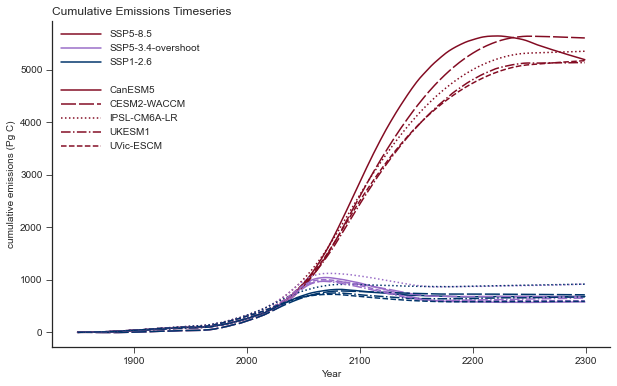

In [33]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, cum_emissions_pgc[0,:, model_i], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, cum_emissions_pgc[1,:, model_i], color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(years, cum_emissions_pgc[2,:, model_i], color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('cumulative emissions (Pg C)')
plt.xlabel('Year')
plt.title('Cumulative Emissions Timeseries',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False, handlelength=4)
plt.savefig('cumulative_emissions_timeseries.png', dpi=300, format='png')

(3, 450, 5)


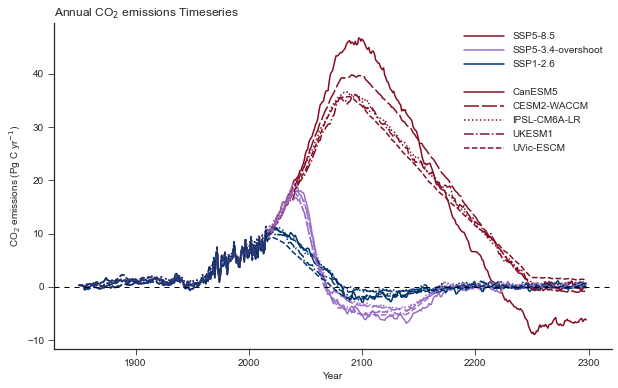

In [34]:
ax = plt.subplot(111)
print(cum_emissions_pgc.shape)
annual_emissions_pgc = cum_emissions_pgc.copy()
annual_emissions_pgc[:,-1,:] = None
annual_emissions_pgc[:,:-1,:] = np.diff(cum_emissions_pgc, axis=1)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, annual_emissions_pgc[0,:, model_i], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, annual_emissions_pgc[1,:, model_i], color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(years, annual_emissions_pgc[2,:, model_i], color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ emissions (Pg C yr$^{-1}$)')
plt.xlabel('Year')
plt.title('Annual CO$_2$ emissions Timeseries',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False, handlelength=4)

In [35]:
### read in co2 emission sdata from IAM extensions
iam_emissions_filename = 'rcmip-emissions-annual-means-v5-1-0.csv'
iam_emissions_file = pd.read_csv(iam_emissions_filename)

ssp534os_co2emiss = iam_emissions_file[(iam_emissions_file.Scenario == 'ssp534-over') * (iam_emissions_file.Variable == 'Emissions|CO2|MAGICC Fossil and Industrial') * (iam_emissions_file.Region == 'World')]
ssp585_co2emiss = iam_emissions_file[(iam_emissions_file.Scenario == 'ssp585') * (iam_emissions_file.Variable == 'Emissions|CO2|MAGICC Fossil and Industrial') * (iam_emissions_file.Region == 'World')]
ssp126_co2emiss = iam_emissions_file[(iam_emissions_file.Scenario == 'ssp126') * (iam_emissions_file.Variable == 'Emissions|CO2|MAGICC Fossil and Industrial') * (iam_emissions_file.Region == 'World')]



/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [36]:
iam_emissions = xr.DataArray(np.ma.masked_all((3,nyears_total)), dims=['scenarios','time'], coords=[np.arange(3), np.arange(nyears_total)+1850.])

iam_emissions[1,:] = ssp534os_co2emiss.iloc[0,107:557]
iam_emissions[0,:] = ssp585_co2emiss.iloc[0,107:557]
iam_emissions[2,:] = ssp126_co2emiss.iloc[0,107:557]

In [37]:
iam_emissions_nomissing = iam_emissions.dropna(dim='time')

(3, 450, 5)


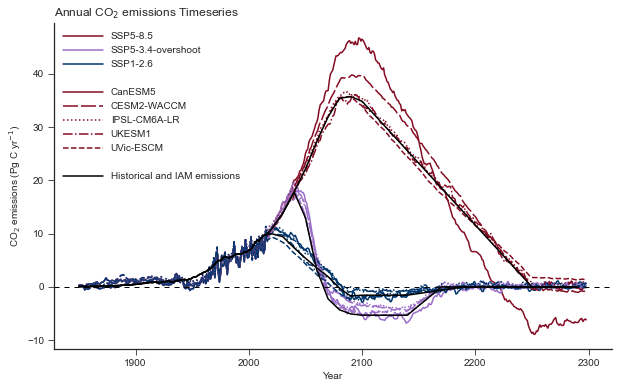

In [38]:
ax = plt.subplot(111)
print(cum_emissions_pgc.shape)
annual_emissions_pgc = cum_emissions_pgc.copy()
annual_emissions_pgc[:,-1,:] = None
annual_emissions_pgc[:,:-1,:] = np.diff(cum_emissions_pgc, axis=1)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, annual_emissions_pgc[0,:, model_i], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, annual_emissions_pgc[1,:, model_i], color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(years, annual_emissions_pgc[2,:, model_i], color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

a3, = ax.plot(iam_emissions_nomissing.time, iam_emissions_nomissing[0,:]*1e-3 * 12/44, color='black')        
ax.plot(iam_emissions_nomissing.time, iam_emissions_nomissing[1,:]*1e-3 * 12/44, color='black')        
ax.plot(iam_emissions_nomissing.time, iam_emissions_nomissing[2,:]*1e-3 * 12/44, color='black')        


ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ emissions (Pg C yr$^{-1}$)')
plt.xlabel('Year')
plt.title('Annual CO$_2$ emissions Timeseries',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

linelist_wiam = list(linelist)
labels_list_wiam = list(labels_list)

linelist_wiam.append(emptyline)
labels_list_wiam.append(None)

linelist_wiam.append(a3)
labels_list_wiam.append('Historical and IAM emissions')



plt.legend(linelist_wiam, labels_list_wiam, frameon=False, handlelength=4)
plt.savefig('annual_emissions_timeseries.png', dpi=300, format='png')

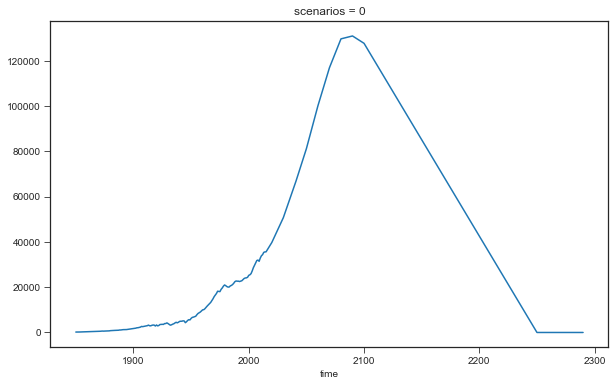

In [39]:
### need to interpolate annual numbers fore long-term IAM emissions
iam_emissions_nomissing.interp(time=years)[0,:].plot()

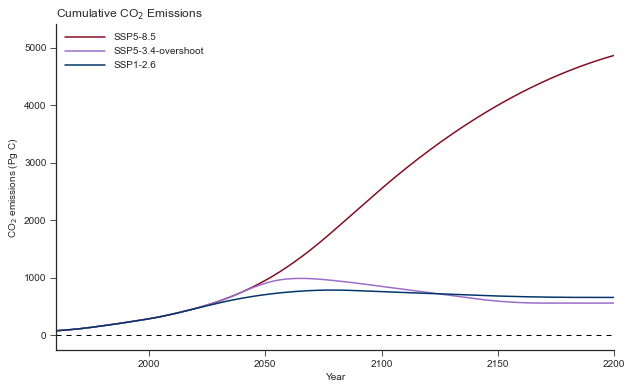

In [40]:
iam_cumulative_emissions  = iam_emissions_nomissing.interp(time=years).cumsum(dim='time')*1e-3 * 12/44

ax = plt.subplot(111)

a1, = ax.plot(years, iam_cumulative_emissions[0,:], color=ssp585_color)        
a2, = ax.plot(years, iam_cumulative_emissions[1,:], color=ssp534os_color)        
a3, = ax.plot(years, iam_cumulative_emissions[2,:], color=ssp126_color)        


ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ emissions (Pg C)')
plt.xlabel('Year')
plt.title('Cumulative CO$_2$ Emissions',loc='left')
plt.xlim([1960.,2200.])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

linelist_wiam = list(linelist)
labels_list_wiam = list(labels_list)

linelist_wiam.append(emptyline)
labels_list_wiam.append(None)

linelist_wiam.append(a3)
labels_list_wiam.append('Historical and IAM emissions')



plt.legend([a1,a2,a3], labels_list_wiam, frameon=False, handlelength=4)
plt.savefig('cumiulative_emissions_timeseries.png', dpi=300, format='png')

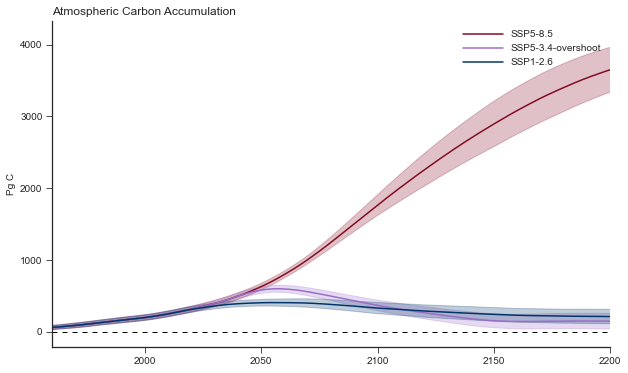

In [41]:
atmospheric_accumulation = iam_cumulative_emissions - cumulative_sink


ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, atmospheric_accumulation[0,:,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, atmospheric_accumulation[0,:,:].mean(dim='models')-atmospheric_accumulation[0,:,:].std(dim='models'), atmospheric_accumulation[0,:,:].mean(dim='models')+atmospheric_accumulation[0,:,:].std(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, atmospheric_accumulation[1,:,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, atmospheric_accumulation[1,:,:].mean(dim='models')-atmospheric_accumulation[1,:,:].std(dim='models'), atmospheric_accumulation[1,:,:].mean(dim='models')+atmospheric_accumulation[1,:,:].std(dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, atmospheric_accumulation[2,:,:].mean(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, atmospheric_accumulation[2,:,:].mean(dim='models')-atmospheric_accumulation[2,:,:].std(dim='models'), atmospheric_accumulation[2,:,:].mean(dim='models')+atmospheric_accumulation[2,:,:].std(dim='models'), color=ssp126_color, alpha=transparency)
plt.xlim([1960.,2200.])


    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Pg C')
plt.title('Atmospheric Carbon Accumulation', loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('atmospheric_timeseries_meanstd.png', dpi=300, format='png')




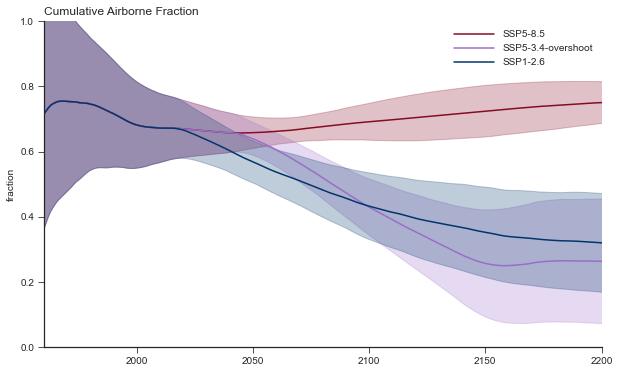

In [42]:
cumulative_airborne_fraction = atmospheric_accumulation / iam_cumulative_emissions


ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, cumulative_airborne_fraction[0,:,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, cumulative_airborne_fraction[0,:,:].mean(dim='models')-cumulative_airborne_fraction[0,:,:].std(dim='models'), cumulative_airborne_fraction[0,:,:].mean(dim='models')+cumulative_airborne_fraction[0,:,:].std(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, cumulative_airborne_fraction[1,:,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, cumulative_airborne_fraction[1,:,:].mean(dim='models')-cumulative_airborne_fraction[1,:,:].std(dim='models'), cumulative_airborne_fraction[1,:,:].mean(dim='models')+cumulative_airborne_fraction[1,:,:].std(dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, cumulative_airborne_fraction[2,:,:].mean(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, cumulative_airborne_fraction[2,:,:].mean(dim='models')-cumulative_airborne_fraction[2,:,:].std(dim='models'), cumulative_airborne_fraction[2,:,:].mean(dim='models')+cumulative_airborne_fraction[2,:,:].std(dim='models'), color=ssp126_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('fraction')
plt.title('Cumulative Airborne Fraction', loc='left')
plt.ylim([0.,1.])
plt.xlim([1960.,2200.])



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('atmospheric_cumulative_airbornefrac.png', dpi=300, format='png')




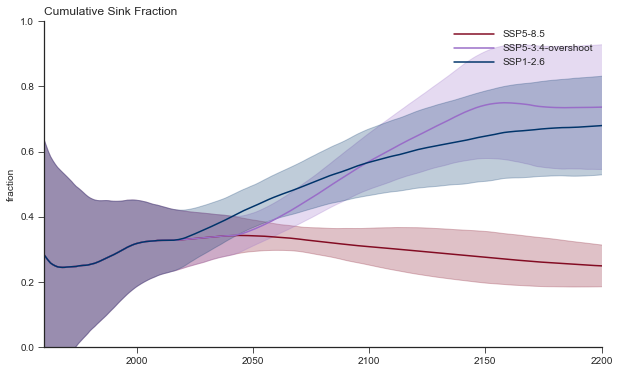

In [43]:
cumulative_sink_fraction = cumulative_sink / iam_cumulative_emissions


ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, cumulative_sink_fraction[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, cumulative_sink_fraction[:,0,:].mean(dim='models')-cumulative_sink_fraction[:,0,:].std(dim='models'), cumulative_sink_fraction[:,0,:].mean(dim='models')+cumulative_sink_fraction[:,0,:].std(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, cumulative_sink_fraction[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, cumulative_sink_fraction[:,1,:].mean(dim='models')-cumulative_sink_fraction[:,1,:].std(dim='models'), cumulative_sink_fraction[:,1,:].mean(dim='models')+cumulative_sink_fraction[:,1,:].std(dim='models'), color=ssp534os_color, alpha=transparency)

a3, = ax.plot(years, cumulative_sink_fraction[:,2,:].mean(dim='models'), color=ssp126_color)
f1 = ax.fill_between(years, cumulative_sink_fraction[:,2,:].mean(dim='models')-cumulative_sink_fraction[:,2,:].std(dim='models'), cumulative_sink_fraction[:,2,:].mean(dim='models')+cumulative_sink_fraction[:,2,:].std(dim='models'), color=ssp126_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('fraction')
plt.title('Cumulative Sink Fraction', loc='left')
plt.ylim([0.,1.])
plt.xlim([1960.,2200.])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2,a3], labels_list[0:3], frameon=False, handlelength=4)

plt.savefig('cumulative_sinkfrac.png', dpi=300, format='png')





In [44]:
atm_accumulation = atm_co2_pgc.copy()
atm_accumulation[:,1:] = np.diff(atm_co2_pgc, axis=1)
atm_accumulation = atm_accumulation.rolling(time=nyear_smooth).mean()
esm_emissions_ensmean = annual_emissions_pgc.mean(dim='models').rolling(time=nyear_smooth).mean()

lnd_flux_ensmean = nbp_trajectories_2exp.mean(dim='models').rolling(time=nyear_smooth).mean()
ocn_flux_ensmean = fgco2_trajectories_2exp.mean(dim='models').rolling(time=nyear_smooth).mean()


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


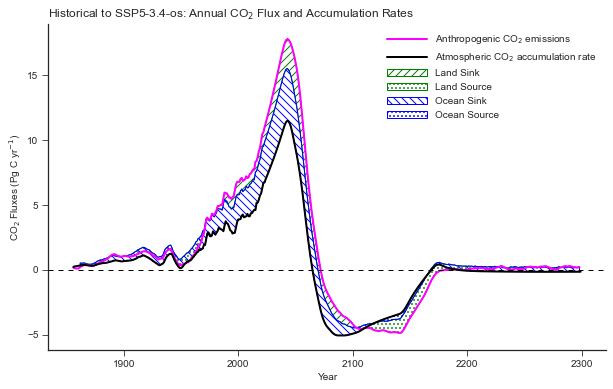

In [45]:
ax = plt.subplot(111)

scen_i = 1

a1, = ax.plot(years, esm_emissions_ensmean[scen_i,:], color='magenta', linewidth=2.)
a2, = ax.plot(years, atm_accumulation[scen_i,:], color='black', linewidth=2.)
a3 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='///', where=(lnd_flux_ensmean[scen_i,:] >= 0.))
a4 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='...', where=(lnd_flux_ensmean[scen_i,:] <= 0.))
a5 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], atm_accumulation[scen_i,:], facecolor='none', edgecolor='blue', hatch='\\\\\\', where=(ocn_flux_ensmean[scen_i,:] >= 0.))
a6 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], atm_accumulation[scen_i,:], facecolor='none', edgecolor='blue', hatch='...', where=(ocn_flux_ensmean[scen_i,:] <= 0.))

linelist = [a1,a2,a3,a4,a5,a6]
labels_list_allfluxplot = ['Anthropogenic CO$_2$ emissions', 'Atmospheric CO$_2$ accumulation rate', 'Land Sink', 'Land Source', 'Ocean Sink', 'Ocean Source']

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ Fluxes (Pg C yr$^{-1}$)')
plt.xlabel('Year')
plt.title('Historical to SSP5-3.4-os: Annual CO$_2$ Flux and Accumulation Rates',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list_allfluxplot, frameon=False, handlelength=4)
plt.savefig('ssp534os_fluxes_all.png', dpi=300, format='png')

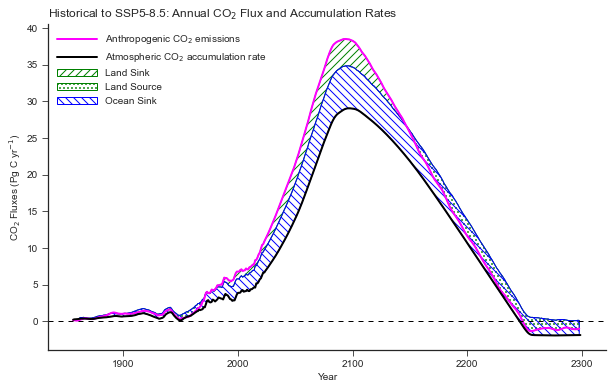

In [46]:
ax = plt.subplot(111)

scen_i = 0

a1, = ax.plot(years, esm_emissions_ensmean[scen_i,:], color='magenta', linewidth=2.)
a2, = ax.plot(years, atm_accumulation[scen_i,:], color='black', linewidth=2.)
a3 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='///', where=(lnd_flux_ensmean[scen_i,:] >= 0.))
a4 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='...', where=(lnd_flux_ensmean[scen_i,:] <= 0.))
a5 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], atm_accumulation[scen_i,:], facecolor='none', edgecolor='blue', hatch='\\\\\\', where=(ocn_flux_ensmean[scen_i,:] >= 0.))

linelist = [a1,a2,a3,a4,a5]
labels_list_allfluxplot = ['Anthropogenic CO$_2$ emissions', 'Atmospheric CO$_2$ accumulation rate', 'Land Sink', 'Land Source', 'Ocean Sink']

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ Fluxes (Pg C yr$^{-1}$)')
plt.xlabel('Year')
plt.title('Historical to SSP5-8.5: Annual CO$_2$ Flux and Accumulation Rates',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list_allfluxplot, frameon=False, handlelength=4)
plt.savefig('ssp585_fluxes_all.png', dpi=300, format='png')

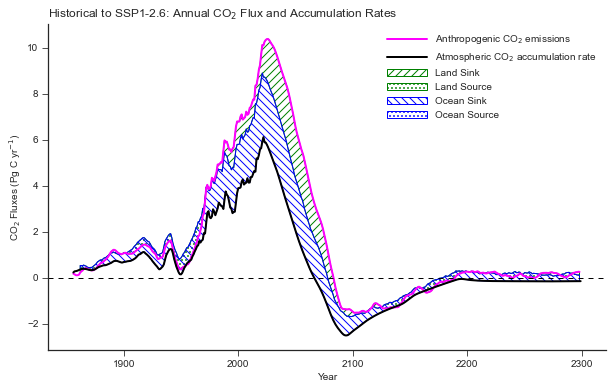

In [47]:
ax = plt.subplot(111)

scen_i = 2

a1, = ax.plot(years, esm_emissions_ensmean[scen_i,:], color='magenta', linewidth=2.)
a2, = ax.plot(years, atm_accumulation[scen_i,:], color='black', linewidth=2.)
a3 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='///', where=(lnd_flux_ensmean[scen_i,:] >= 0.))
a4 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='...', where=(lnd_flux_ensmean[scen_i,:] <= 0.))
a5 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], atm_accumulation[scen_i,:], facecolor='none', edgecolor='blue', hatch='\\\\\\', where=(ocn_flux_ensmean[scen_i,:] >= 0.))
a6 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], atm_accumulation[scen_i,:], facecolor='none', edgecolor='blue', hatch='...', where=(ocn_flux_ensmean[scen_i,:] <= 0.))

linelist = [a1,a2,a3,a4,a5,a6]
labels_list_allfluxplot = ['Anthropogenic CO$_2$ emissions', 'Atmospheric CO$_2$ accumulation rate', 'Land Sink', 'Land Source', 'Ocean Sink', 'Ocean Source']

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ Fluxes (Pg C yr$^{-1}$)')
plt.xlabel('Year')
plt.title('Historical to SSP1-2.6: Annual CO$_2$ Flux and Accumulation Rates',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list_allfluxplot, frameon=False, handlelength=4)
plt.savefig('ssp126_fluxes_all.png', dpi=300, format='png')

In [48]:
#labels_list = tuple(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6', ''] + list(models_list))



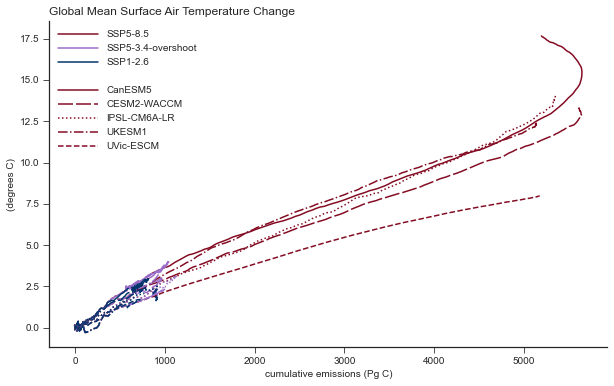

In [49]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(cum_emissions_pgc[0,:, model_i], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(cum_emissions_pgc[2,:, model_i], tas_trajectories_2exp[model_i,2,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False, handlelength=4)
plt.savefig('temp_vs_cumulative_emissions_both_ssps.png', dpi=300, format='png')

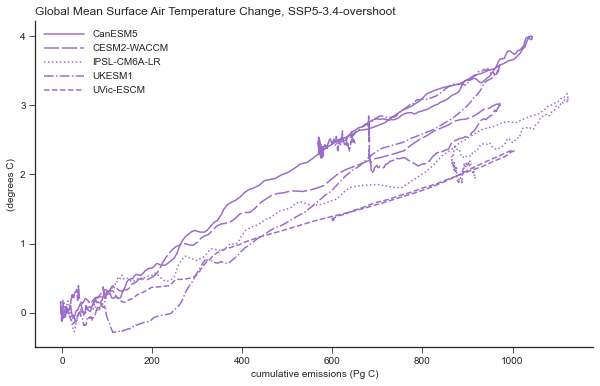

In [50]:
### just show the SSP5-3.4os
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    linelist.append(a1)

emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change, SSP5-3.4-overshoot',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, models_list, frameon=False, handlelength=4)

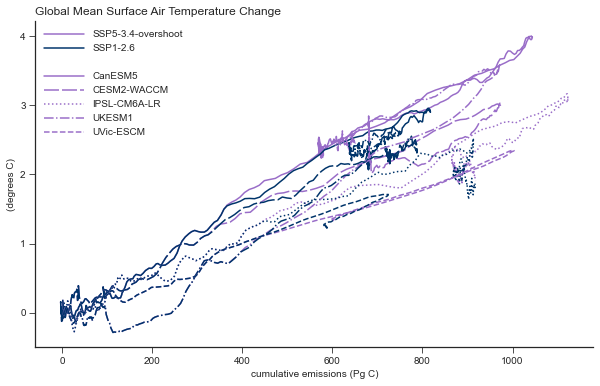

In [51]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a2, = ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    a3, = ax.plot(cum_emissions_pgc[2,:, model_i], tas_trajectories_2exp[model_i,2,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a2)
        linelist.append(a3)
        emptyline, = ax.plot([500,500], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a2)
    else:
        linelist.append(a2)

emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list[1:], frameon=False, handlelength=4)
plt.savefig('temp_vs_cumulative_emissions_ssps_526os_126.png', dpi=300, format='png')

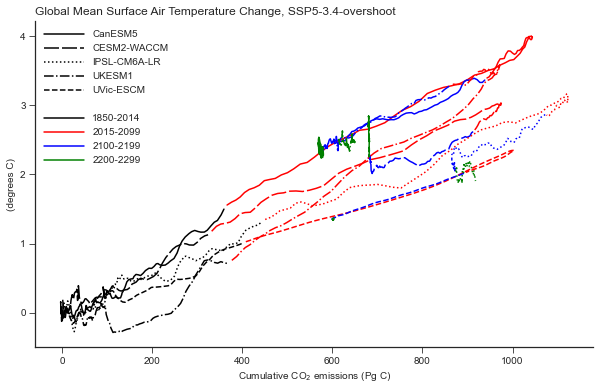

In [52]:
### just show the SSP5-3.4os, but color based on the century
ax = plt.subplot(111)

period_list = ['1850-2014','2015-2099','2100-2199','2200-2299']
period_tstart = np.array([1850,2015,2100,2200], dtype=np.int)-1850
period_tend = np.array([2015,2100,2200,2300], dtype=np.int)-1850
colors = ['black','red','blue','green']
linelist = []
linelist2 = []
for model_i in range(nmodels):
    for period_i in range(len(period_list)):
        a1, = ax.plot(cum_emissions_pgc[1,period_tstart[period_i]:period_tend[period_i], model_i], tas_trajectories_2exp[model_i,1,period_tstart[period_i]:period_tend[period_i]] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=colors[period_i], linestyle=dashlist[model_i])
        if period_i == 0:
            linelist.append(a1)
        if model_i == 0:
            if period_i == 0:
                emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)
                linelist2.append(emptyline)
            linelist2.append(a1)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('Cumulative CO$_2$ emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change, SSP5-3.4-overshoot',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist+linelist2, list(models_list)+['']+period_list, frameon=False, handlelength=4)
plt.savefig('temp_vs_cumulative_emissions_ssp534os_bycentury.png', dpi=300, format='png')

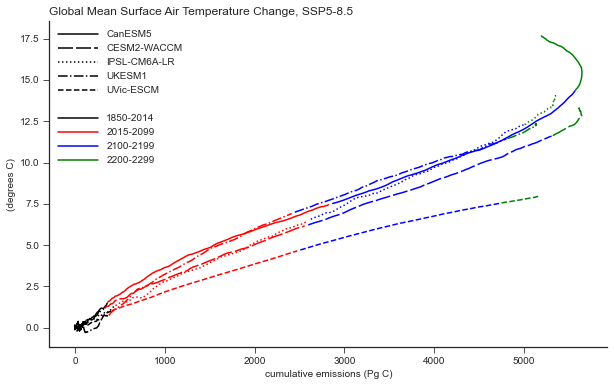

In [53]:
### just show the SSP5-8.5, but color based on the century
ax = plt.subplot(111)

linelist = []
linelist2 = []
for model_i in range(nmodels):
    for period_i in range(len(period_list)):
        a1, = ax.plot(cum_emissions_pgc[0,period_tstart[period_i]:period_tend[period_i], model_i], tas_trajectories_2exp[model_i,0,period_tstart[period_i]:period_tend[period_i]] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=colors[period_i], linestyle=dashlist[model_i])
        if period_i == 0:
            linelist.append(a1)
        if model_i == 0:
            if period_i == 0:
                emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)
                linelist2.append(emptyline)
            linelist2.append(a1)


#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change, SSP5-8.5',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist+linelist2, list(models_list)+['']+period_list, frameon=False, handlelength=4)
plt.savefig('temp_vs_cumulative_emissions_ssp585_bycentury.png', dpi=300, format='png')

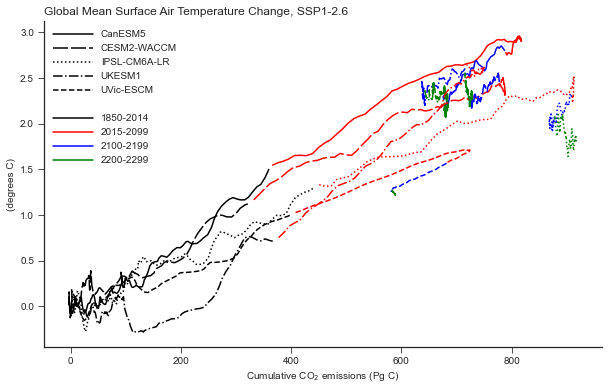

In [54]:
### just show the SSP51-2.6, but color based on the century
ax = plt.subplot(111)

period_list = ['1850-2014','2015-2099','2100-2199','2200-2299']
period_tstart = np.array([1850,2015,2100,2200], dtype=np.int)-1850
period_tend = np.array([2015,2100,2200,2300], dtype=np.int)-1850
colors = ['black','red','blue','green']
linelist = []
linelist2 = []
for model_i in range(nmodels):
    for period_i in range(len(period_list)):
        a1, = ax.plot(cum_emissions_pgc[2,period_tstart[period_i]:period_tend[period_i], model_i], tas_trajectories_2exp[model_i,2,period_tstart[period_i]:period_tend[period_i]] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=colors[period_i], linestyle=dashlist[model_i])
        if period_i == 0:
            linelist.append(a1)
        if model_i == 0:
            if period_i == 0:
                emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)
                linelist2.append(emptyline)
            linelist2.append(a1)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('Cumulative CO$_2$ emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change, SSP1-2.6',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist+linelist2, list(models_list)+['']+period_list, frameon=False, handlelength=4)
plt.savefig('temp_vs_cumulative_emissions_ssp126_bycentury.png', dpi=300, format='png')

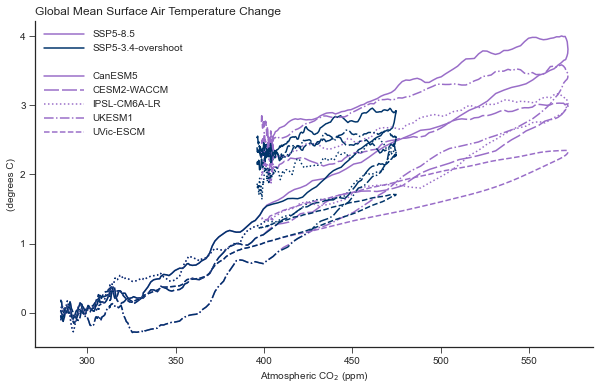

In [55]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    a2, = ax.plot(co2_mf_ts[2,:], tas_trajectories_2exp[model_i,2,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp126_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([500,500], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)



#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('Atmospheric CO$_2$ (ppm)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list[0:2]+labels_list[3:], frameon=False, handlelength=4)

plt.savefig('temp_vs_co2conc_ssp534os_ssp126.png', dpi=300, format='png')


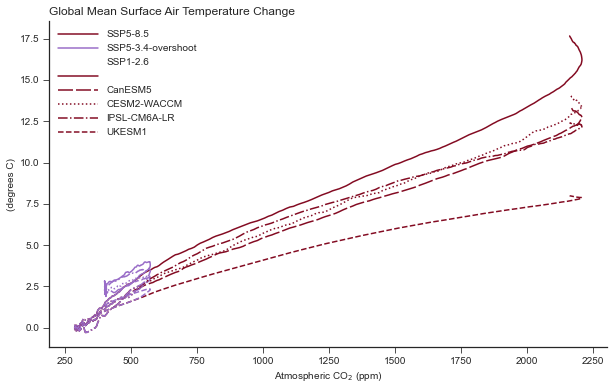

In [56]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(co2_mf_ts[0,:], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([500,500], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)



#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('Atmospheric CO$_2$ (ppm)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False, handlelength=4)



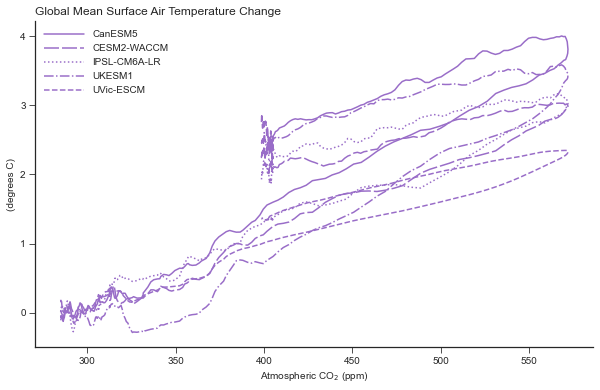

In [57]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    linelist.append(a1)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('Atmospheric CO$_2$ (ppm)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, models_list, frameon=False, handlelength=4)




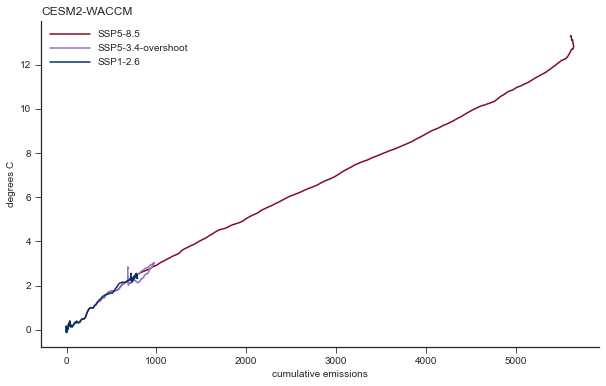

In [58]:
### look at any one model on its own...
model_i = models_list.index('CESM2-WACCM')

ax = plt.subplot(111)
ax.plot(cum_emissions_pgc[0,:, model_i], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color)
ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color)
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
ax.plot(cum_emissions_pgc[2,:, model_i], tas_trajectories_2exp[model_i,2,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp126_color)
plt.ylabel('degrees C')
plt.xlabel('cumulative emissions')
plt.title(models_list[model_i],loc='left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6'], frameon=False, handlelength=4)

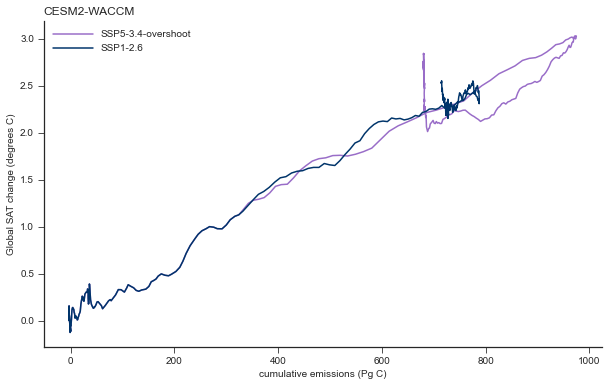

In [59]:
### look at any one model on its own...
model_i = models_list.index('CESM2-WACCM')

ax = plt.subplot(111)
ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color)
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
ax.plot(cum_emissions_pgc[2,:, model_i], tas_trajectories_2exp[model_i,2,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp126_color)
plt.ylabel('Global SAT change (degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title(models_list[model_i],loc='left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-3.4-overshoot', 'SSP1-2.6'], frameon=False, handlelength=4)

In [60]:
### print 50-year means to make a waterfall plot as in Jones et al.
### for each period, want: startyear, endyear, mean(inferred emissions), std(inferred emissions), mean(land flux), std(land flux), mean(ocn flux), std(ocn flux) 

waterfall_figs_period_timeperiods = [[2000,2049],[2050,2099],[2100,2149],[2150,2199],[2200,2249],[2250,2299]]
n_waterfall_periods = len(waterfall_figs_period_timeperiods)

print('scen_name','year_start','year_end','mean_emissions','std_emissions','mean_lnd_flux','std_lnd_flux','mean_ocn_flux','std_ocn_flux')
for scen_j in range(n_future_scens):
    scen_name = exps_list[scen_j+1]
    for i_period in range(n_waterfall_periods):
        ystart = waterfall_figs_period_timeperiods[i_period][0]
        yend = waterfall_figs_period_timeperiods[i_period][1]
        tindx_start = ystart - 1850
        tindx_end = yend - 1850
        #
        mean_emissions = annual_emissions_pgc.isel(scenarios=scen_j).isel(time=[tindx_start,tindx_end]).mean(dim='time').mean(dim='models').data
        std_emissions = annual_emissions_pgc.isel(scenarios=scen_j).isel(time=[tindx_start,tindx_end]).mean(dim='time').std(dim='models').data
        #
        mean_lnd_flux = nbp_trajectories_2exp.isel(scenarios=scen_j).isel(time=[tindx_start,tindx_end]).mean(dim='time').mean(dim='models').data
        std_lnd_flux = nbp_trajectories_2exp.isel(scenarios=scen_j).isel(time=[tindx_start,tindx_end]).mean(dim='time').std(dim='models').data
        #
        mean_ocn_flux = fgco2_trajectories_2exp.isel(scenarios=scen_j).isel(time=[tindx_start,tindx_end]).mean(dim='time').mean(dim='models').data
        std_ocn_flux = fgco2_trajectories_2exp.isel(scenarios=scen_j).isel(time=[tindx_start,tindx_end]).mean(dim='time').std(dim='models').data
        #
        print(scen_name,ystart,yend,mean_emissions,std_emissions,mean_lnd_flux,std_lnd_flux,mean_ocn_flux,std_ocn_flux)
    

scen_name year_start year_end mean_emissions std_emissions mean_lnd_flux std_lnd_flux mean_ocn_flux std_ocn_flux
ssp585 2000 2049 14.19426769220053 0.6105649181126546 1.782564384168608 0.5645515581727093 3.2270759521418713 0.23894964050784026
ssp585 2050 2099 30.532985254888207 2.811026466371914 3.151602004414202 3.0327484056722103 5.114870170974191 0.42793025105247956
ssp585 2100 2149 31.65434265401145 3.481054470277741 1.5582344684336307 3.997846370955557 5.013867392789915 0.6564637284856917
ssp585 2150 2199 18.08343720911453 1.2342901115392082 -1.256578587683887 1.6826192401350268 3.861320612815713 0.7817964269633338
ssp585 2200 2249 4.97897758445597 2.9350371887739413 -2.0198023711142006 2.4942624494560786 2.9083268113554395 0.8113014218276414
ssp585 2250 2299 -1.3507755945991449 3.7718589418959136 -1.4806694832867022 2.6731952107131733 2.187665487002225 0.783017557998229
ssp534-over 2000 2049 10.661343698057468 0.7221926151719166 1.9839385371793739 0.7777974240038447 3.07267128635

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### below is code to search the ESG and see what variables exist for the 21st and 22nd centuries

In [61]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        ##cdk print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [62]:
century_strings = ['-22', '-23']

In [63]:
ssp585_nbp_files = esgf_search(variable_id='nbp', experiment_id='ssp585')
for url in ssp585_nbp_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc
http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1

In [64]:
ssp534os_nbp_files = esgf_search(variable_id='nbp', experiment_id='ssp534-over')
for url in ssp534os_nbp_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20190306/nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc
http://esgf-data1.llnl.gov/thredds/dodsC/css03_

In [65]:
ssp534os_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp534-over')
for url in ssp534os_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20190306/fgco2_Omon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20200701/fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroo

In [66]:
ssp585_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp585')
for url in ssp585_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Omon/fgco2/gn/v20200702/fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Omon/fgco2/gn/v20200702/fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/

In [67]:
ssp585_tas_files = esgf_search(variable_id='tas', experiment_id='ssp585')
for url in ssp585_tas_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Amon/tas/gn/v20200702/tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Amon/tas/gn/v20200702/tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Amon/tas/gn/v20200702/tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1

In [68]:
ssp534os_tas_files = esgf_search(variable_id='tas', experiment_id='ssp534-over')
for url in ssp534os_tas_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Amon/tas/gn/v20190306/tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/day/tas/gn/v20190306/tas_day_CanESM5_ssp534-over_r1i1p1f1_gn_21010101-23001231.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/day/tas/gn/v20190429/tas_day_CanESM5_ssp534-over_r1i1p1f1_gn_21010101-23001231.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Amon/tas/gn/v20200701/tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CM

In [69]:
ssp534os_cveg_files = esgf_search(variable_id='cSoil', experiment_id='ssp534-over')
for url in ssp534os_cveg_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Emon/cSoil/gn/v20190306/cSoil_Emon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Emon/cSoil/gn/v20190429/cSoil_Emon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Emon/cSoil/gn/v20200701/cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Emon/cSoil/gn/v20200701/cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Emon/cSoil/gn/v20200701/cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc
http://esgf-data.ucar.edu/t

In [70]:
ssp126_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp126')
for url in ssp126_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp126/r1i1p1f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012.nc
http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp126/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp126_r1i1p1f1_gn_2101-2300.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp126/r1i1p1f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp126/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp126_r1i1p1f1_gn_2101-2300.nc
http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp126/r1i1p1f1/Omon/fgco2/gn/v20190903/fgco2_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gn_210101-230012.nc
http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp126/r1i1p

In [71]:
ssp126_fgco2_files = esgf_search(variable_id='areacella', experiment_id='ssp126')
for url in ssp126_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

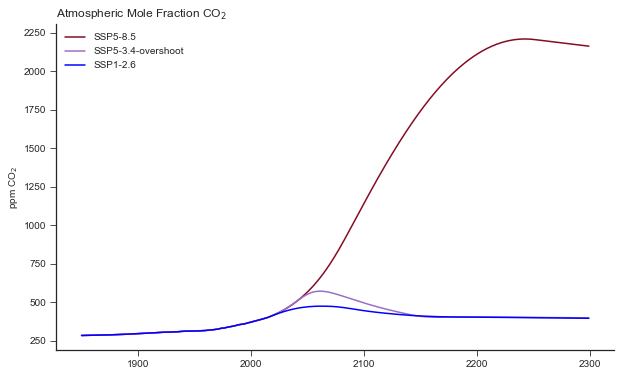

In [72]:
## now load the atmospheric mole fraction of co2 to calculate the cumulative emissions
filename_atmco2_hist = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc'
filename_atmco2_ssp585 = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc'
filename_atmco2_ssp534os = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp534-over-1-2-1_gr1-GMNHSH_2015-2500.nc'
filename_atmco2_ssp126 = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc'


tmin_co2mf_hist = 0
tmin_co2mf_ssps = 2015


#startyear_exps = [1850, 2015, 2040]
#endyear_exps = [2014, 2299, 2299]

co2_mf_ts_v2 = xr.DataArray(np.ma.masked_all((3,nyears_total)), dims=['scenarios','time'])

co2_molefrac_hist = xr.open_dataset(filename_atmco2_hist, decode_times=False)
hist_co2_ts = co2_molefrac_hist['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[0]-tmin_co2mf_hist,endyear_exps[0]-tmin_co2mf_hist+1))
co2_mf_ts_v2[:,0:endyear_exps[0]-startyear_exps[0]+1] = hist_co2_ts

co2_molefrac_ssp585 = xr.open_dataset(filename_atmco2_ssp585, decode_times=False)
ssp585_co2_ts = co2_molefrac_ssp585['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts_v2[0,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp585_co2_ts

co2_molefrac_ssp534os = xr.open_dataset(filename_atmco2_ssp534os, decode_times=False)
ssp534os_co2_ts = co2_molefrac_ssp534os['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts_v2[1,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp534os_co2_ts

co2_molefrac_ssp126 = xr.open_dataset(filename_atmco2_ssp126, decode_times=False)
ssp126_co2_ts = co2_molefrac_ssp126['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts_v2[2,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp126_co2_ts


#co2_mf_ts.plot()

ax = plt.subplot(111)

ax.plot(years, co2_mf_ts_v2[0,:], color=ssp585_color)
ax.plot(years, co2_mf_ts_v2[1,:], color=ssp534os_color)
ax.plot(years, co2_mf_ts_v2[2,:], color='blue')

    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('ppm CO$_2$')
plt.title('Atmospheric Mole Fraction CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6'], frameon=False)